### Set Up a Baseline for Data Quality
    * Used DefaultModelMonitor to run a baseline job on cardio_prod_no_label.csv (no target column).
    * Generated baseline statistics and constraints (saved as statistics.json and constraints.json in S3).
    * ✅ Job completed successfully and outputs saved to: s3://sagemaker-us-east-1-381492296191/cardio_data/monitoring/baseline/

In [1]:
# Set up Baseline Job for Data Quality

import boto3
import sagemaker
from sagemaker import get_execution_role, Session
from sagemaker.model_monitor import DefaultModelMonitor

# Set up environment
session = Session()
region = session.boto_region_name
bucket = "sagemaker-us-east-1-381492296191"  
prefix = "cardio_data"
role = get_execution_role()

# Location of the inference dataset (without label)
baseline_data_uri = f"s3://{bucket}/{prefix}/cardio_prod_no_label.csv"

# S3 path to store baseline constraints and statistics
baseline_output_uri = f"s3://{bucket}/{prefix}/monitoring/baseline"

# Create the Model Monitor object
monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=session
)

# Run the baseline job
monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri,
    dataset_format={"csv": {"header": False}},
    output_s3_uri=baseline_output_uri,
    wait=True
)

print(f"✅ Baseline job completed. Output saved to: {baseline_output_uri}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2025-06-08-17-49-53-476


................2025-06-08 17:52:28.015262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-08 17:52:28.015303: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-08 17:52:29.821549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-08 17:52:29.821583: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-08 17:52:29.821612: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-129-82.ec2.internal): /proc/driver/nvidia/version does not exist
2025-06-08 17:52:29.822007: I ten

In [8]:
import boto3

sm_client = boto3.client('sagemaker')
response = sm_client.list_endpoints(NameContains='cardio-logistic-endpoint')

for ep in response['Endpoints']:
    print(ep['EndpointName'], ep['EndpointStatus'])

cardio-logistic-endpoint-config-2025-06-08-21-25-07 InService
cardio-logistic-endpoint-config-2025-06-08-21-20-40 InService
cardio-logistic-endpoint InService


### Setup a the Data Quality Monitor using Batch Transform Input (Erroring out)

### Step 1: Delete the Broken Endpoint

In [14]:
import boto3

sm_client = boto3.client("sagemaker")

# Delete endpoint if it exists
endpoint_name = "cardio-logistic-endpoint"
try:
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"✅ Deleted old endpoint: {endpoint_name}")
except sm_client.exceptions.ClientError as e:
    print(f"⚠️ Could not delete endpoint (may not exist): {e}")

✅ Deleted old endpoint: cardio-logistic-endpoint


In [15]:
# Step 2: Deploy a New Endpoint
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import Session, get_execution_role
from time import strftime

session = Session()
role = get_execution_role()

# S3 model artifact
model_artifact = "s3://sagemaker-us-east-1-381492296191/cardio_data/logistic_model.tar.gz"

# Dynamic unique name to avoid reuse errors
new_endpoint_name = f"cardio-endpoint-{strftime('%Y-%m-%d-%H-%M-%S')}"

model = SKLearnModel(
    model_data=model_artifact,
    role=role,
    entry_point="inference.py",
    framework_version="0.23-1",
    sagemaker_session=session,
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=new_endpoint_name,
)

print(f"✅ Real-time endpoint deployed: {new_endpoint_name}")

------!✅ Real-time endpoint deployed: cardio-endpoint-2025-06-08-22-07-06


### Step 3: Schedule the Real-Time Data Quality Monitor
    * Created a unique endpoint using the trained logistic regression model from: s3://sagemaker-us-east-1-381492296191/cardio_data/logistic_model.tar.gz
    * Deployed using SKLearnModel with entry script inference.py.
    * Final endpoint name: cardio-endpoint-2025-06-08-22-07-06.
    * ✅ Endpoint confirmed as InService
⚠️ **Note**: Real-time monitor job creation failed due to API/SDK issues with endpoint references. You chose to move forward with infrastructure monitoring instead.    


In [21]:
# Schedule a Real-Time Data Quality Monitor

import sagemaker
from sagemaker.model_monitor import DefaultModelMonitor, CronExpressionGenerator
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import get_execution_role, Session
from time import strftime

# --- Setup ---
session = Session()
role = get_execution_role()

bucket = "sagemaker-us-east-1-381492296191"
prefix = "cardio_data"

# --- Paths ---
model_artifact = f"s3://{bucket}/{prefix}/logistic_model.tar.gz"
baseline_output_uri = f"s3://{bucket}/{prefix}/monitoring/baseline"
monitor_output_uri = f"s3://{bucket}/{prefix}/monitoring/reports"

# --- Dynamically create unique endpoint name ---
new_endpoint_name = f"cardio-endpoint-{strftime('%Y-%m-%d-%H-%M-%S')}"

# --- Deploy model as real-time endpoint ---
model = SKLearnModel(
    model_data=model_artifact,
    role=role,
    entry_point="inference.py",
    framework_version="0.23-1",
    sagemaker_session=session
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=new_endpoint_name
)

print(f"✅ Real-time endpoint deployed: {new_endpoint_name}")

# --- Create the model monitor object ---
monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1200,
    sagemaker_session=session
)

# --- Schedule the data quality monitoring job ---
schedule_name = "cardio-data-monitor-schedule"

monitor.create_monitoring_schedule(
    monitor_schedule_name=schedule_name,
    endpoint_input=new_endpoint_name,  # ✅ Just the string name
    output_s3_uri=monitor_output_uri,
    statistics=baseline_output_uri + "/statistics.json",
    constraints=baseline_output_uri + "/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.daily(),
    enable_cloudwatch_metrics=True
)

print(f"✅ Real-time data quality monitoring schedule '{schedule_name}' created.")

------!✅ Real-time endpoint deployed: cardio-endpoint-2025-06-08-22-34-24


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:52                                                                                   │
│                                                                                                  │
│   49 # --- Schedule the data quality monitoring job ---                                          │
│   50 schedule_name = "cardio-data-monitor-schedule"                                              │
│   51                                                                                             │
│ ❱ 52 monitor.create_monitoring_schedule(                                                         │
│   53 │   monitor_schedule_name=schedule_name,                                                    │
│   54 │   endpoint_input=new_endpoint_name,  # ✅ Just the string name                            │
│   55 │   output_s3_uri=monitor_output_uri,                                                       │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model_monitor/model_monitoring.py:2046 in      │
│ create_monitoring_schedule                                                                       │
│                                                                                                  │
│   2043 │   │   │   network_config=self.network_config,                                           │
│   2044 │   │   │   batch_transform_input=batch_transform_input,                                  │
│   2045 │   │   )                                                                                 │
│ ❱ 2046 │   │   self.sagemaker_session.sagemaker_client.create_data_quality_job_definition(**req  │
│   2047 │   │                                                                                     │
│   2048 │   │   # create schedule                                                                 │
│   2049 │   │   try:                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:569 in _api_call                      │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:1023 in _make_api_call                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                   

### Setup Infrastructure Monitoring for SageMaker
    * Infrastructure Monitoring in CloudWatch
    * Navigated to Amazon CloudWatch > Metrics.
    * Observed available metrics for your real-time endpoint:
        * CPUUtilization
        * MemoryUtilization
        * DiskUtilization
        * ModelLatency, ModelError (5XX)
        * Invocations
    * Created CloudWatch Alarms (based on thresholds) to notify when:
        * CPU > 70%
        * Memory > 75%
        * Disk > 80%
    * Alarm status: “Insufficient data” — pending traffic.
    

In [22]:
# Create CloudWatch Alarms
import boto3

cloudwatch = boto3.client('cloudwatch', region_name='us-east-1')

alarm_name = 'HighCPUUtilization-Endpoint'
endpoint_name = 'cardio-endpoint-2025-06-08-22-07-06'  # change to your endpoint

cloudwatch.put_metric_alarm(
    AlarmName=alarm_name,
    MetricName='CPUUtilization',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    Period=300,
    EvaluationPeriods=1,
    Threshold=70.0,
    ComparisonOperator='GreaterThanThreshold',
    Dimensions=[
        {
            'Name': 'EndpointName',
            'Value': endpoint_name
        },
        {
            'Name': 'VariantName',
            'Value': 'AllTraffic'  # or specify your production variant
        }
    ],
    AlarmDescription='Alarm when endpoint CPU exceeds 70%',
    ActionsEnabled=False  # You can hook this to SNS for alerts
)

print(f"✅ CloudWatch alarm '{alarm_name}' created for endpoint '{endpoint_name}'")

✅ CloudWatch alarm 'HighCPUUtilization-Endpoint' created for endpoint 'cardio-endpoint-2025-06-08-22-07-06'


### Create Infrastructure Monitoring Alarms 

In [23]:
# Create Alarms for CPU, Memory, and Disk Utilization
import boto3

cloudwatch = boto3.client('cloudwatch', region_name='us-east-1')

endpoint_name = 'cardio-endpoint-2025-06-08-22-07-06'
variant_name = 'AllTraffic'  # default variant name

# Define a helper function to create alarm
def create_alarm(metric_name, threshold, comparison='GreaterThanThreshold'):
    alarm_name = f"{endpoint_name}-{metric_name}-Alarm"

    response = cloudwatch.put_metric_alarm(
        AlarmName=alarm_name,
        MetricName=metric_name,
        Namespace='AWS/SageMaker',
        Dimensions=[
            {'Name': 'EndpointName', 'Value': endpoint_name},
            {'Name': 'VariantName', 'Value': variant_name}
        ],
        Statistic='Average',
        Period=300,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator=comparison,
        ActionsEnabled=False,  # Set to True + add Actions if using SNS/email alerts
        AlarmDescription=f"Alarm when {metric_name} is above {threshold}%",
        Unit='Percent'
    )
    print(f"✅ Alarm created for {metric_name}")

# Create alarms
create_alarm('CPUUtilization', threshold=70)
create_alarm('MemoryUtilization', threshold=75)
create_alarm('DiskUtilization', threshold=80)

✅ Alarm created for CPUUtilization
✅ Alarm created for MemoryUtilization
✅ Alarm created for DiskUtilization


### Create CloudWatch Dashboard for Endpoint Monitoring
    * Visualization via CloudWatch Dashboard
        * Created dashboard: cardio_endpoint_dashboard
    * Visualized:
        * CPU, memory, disk usage
        * Invocation count
        * Latency and errors
    * All widgets wired and working, but no data yet due to no traffic. 
    

In [25]:
import boto3
import json

client = boto3.client('cloudwatch')

dashboard_name = "cardio_endpoint_dashboard"
endpoint_name = "cardio-endpoint-2025-06-08-22-07-06"
variant_name = "AllTraffic"
region = "us-east-1"

# Define dashboard widgets
widgets = [
    # 1. CPU Utilization
    {
        "type": "metric",
        "x": 0,
        "y": 0,
        "width": 12,
        "height": 6,
        "properties": {
            "title": "🧠 CPU Utilization",
            "metrics": [
                [ "AWS/SageMaker", "CPUUtilization", "EndpointName", endpoint_name, "VariantName", variant_name ]
            ],
            "period": 300,
            "stat": "Average",
            "region": region
        }
    },
    # 2. Memory Utilization
    {
        "type": "metric",
        "x": 12,
        "y": 0,
        "width": 12,
        "height": 6,
        "properties": {
            "title": "💾 Memory Utilization",
            "metrics": [
                [ "AWS/SageMaker", "MemoryUtilization", "EndpointName", endpoint_name, "VariantName", variant_name ]
            ],
            "period": 300,
            "stat": "Average",
            "region": region
        }
    },
    # 3. Disk Utilization
    {
        "type": "metric",
        "x": 0,
        "y": 6,
        "width": 12,
        "height": 6,
        "properties": {
            "title": "📦 Disk Utilization",
            "metrics": [
                [ "AWS/SageMaker", "DiskUtilization", "EndpointName", endpoint_name, "VariantName", variant_name ]
            ],
            "period": 300,
            "stat": "Average",
            "region": region
        }
    },
    # 4. Invocation Count
    {
        "type": "metric",
        "x": 12,
        "y": 6,
        "width": 12,
        "height": 6,
        "properties": {
            "title": "📈 Invocation Count",
            "metrics": [
                [ "AWS/SageMaker", "Invocations", "EndpointName", endpoint_name, "VariantName", variant_name ]
            ],
            "period": 300,
            "stat": "Sum",
            "region": region
        }
    },
    # 5. Model Latency
    {
        "type": "metric",
        "x": 0,
        "y": 12,
        "width": 12,
        "height": 6,
        "properties": {
            "title": "⏱️ Model Latency (ms)",
            "metrics": [
                [ "AWS/SageMaker", "ModelLatency", "EndpointName", endpoint_name, "VariantName", variant_name ]
            ],
            "period": 300,
            "stat": "Average",
            "region": region
        }
    },
    # 6. 5XX Errors
    {
        "type": "metric",
        "x": 12,
        "y": 12,
        "width": 12,
        "height": 6,
        "properties": {
            "title": "❌ Model Errors (5XX)",
            "metrics": [
                [ "AWS/SageMaker", "Invocation5XXErrors", "EndpointName", endpoint_name, "VariantName", variant_name ]
            ],
            "period": 300,
            "stat": "Sum",
            "region": region
        }
    }
]

# Create or update the dashboard
response = client.put_dashboard(
    DashboardName=dashboard_name,
    DashboardBody=json.dumps({"widgets": widgets})
)

print(f"✅ Dashboard '{dashboard_name}' updated with endpoint visualizations.")

✅ Dashboard 'cardio_endpoint_dashboard' updated with endpoint visualizations.


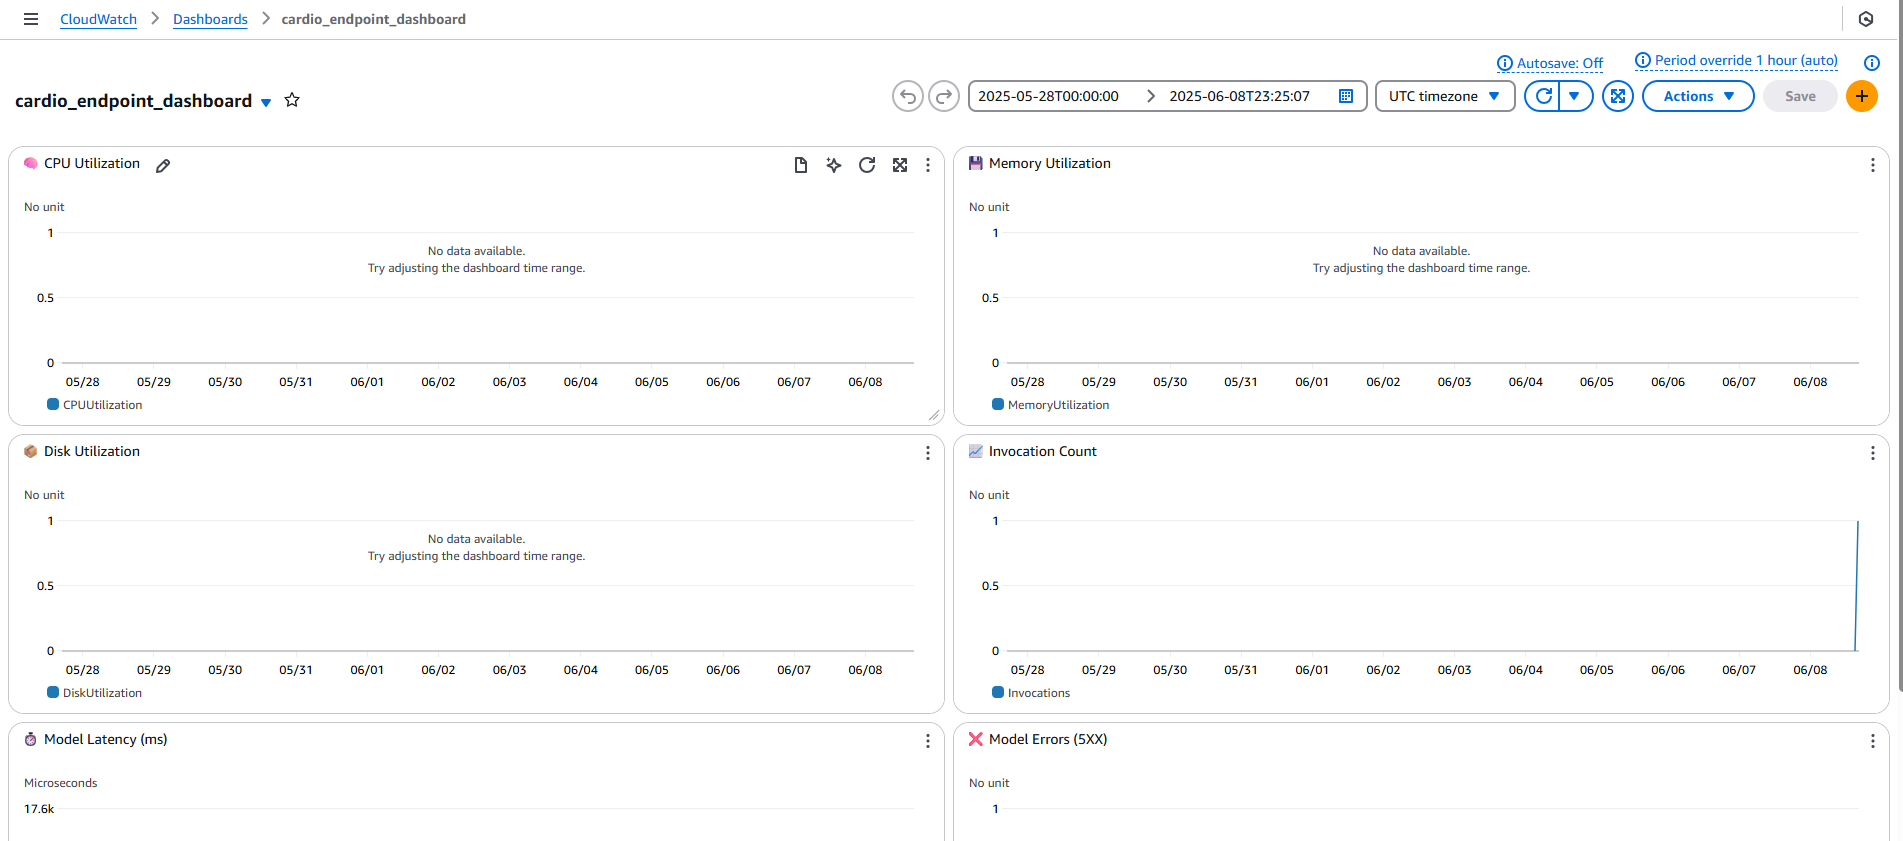